In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules3 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
out_trajectories = output/trajectories/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [2]:
# Load initial and final states and convert to torch
X0       = pt.tensor(np.load(out_trajectories + 'X0.npy'), dtype=pt.float32).to(device)
Xt       = pt.tensor(np.load(out_trajectories + 'Xt.npy'), dtype=pt.float32).to(device)

# Number of dimensions
Nd       = X0.shape[1]

In [3]:
import pickle 

# Load from the file
with open(out_isokann + 'hyperparameters.pkl', 'rb') as file:
    best_hyperparams = pickle.load(file)


print("The best hyperparameters are:", best_hyperparams)

The best hyperparameters are: {'Nepochs': 15, 'nodes': array([  2, 128,   1]), 'learning_rate': 0.001, 'weight_decay': 1e-05, 'batch_size': 100, 'patience': 2, 'act_fun': 'sigmoid'}


In [4]:
# Power method iterations
Niters    = 100

# NN hyperparameters
Nepochs   = best_hyperparams['Nepochs']
nodes     = best_hyperparams['nodes']
lr        = best_hyperparams['learning_rate']
wd        = best_hyperparams['weight_decay']
bs        = best_hyperparams['batch_size']
patience  = best_hyperparams['patience']
act_fun   = best_hyperparams['act_fun']
tolerance = 0.001

f_NN = NeuralNetwork( Nodes =nodes, activation_function = act_fun).to(device)


train_LOSS  = np.empty(0, dtype = object)
val_LOSS    = np.empty(0, dtype = object)
convergence = []

for k in tqdm(range(Niters)):

    old_chi =  f_NN(X0).cpu().detach().numpy()
    f_k                             =  f_NN(Xt)
    mean_f_k                        =  pt.mean(f_k, axis=1)
    f_k1                            =  scale_and_shift(mean_f_k).to(device)
    f_k1                            =  f_k1.clone().detach().requires_grad_(False)
    train_loss, val_loss, best_loss = trainNN(      net        = f_NN, 
                                                    lr         = lr, 
                                                    wd         = wd, 
                                                    Nepochs    = Nepochs, 
                                                    batch_size = bs, 
                                                    patience   = patience,
                                                    test_size  = 0.2,
                                                    X=X0, 
                                                    Y=f_k1)


    train_LOSS = np.append(train_LOSS, train_loss) #[-1]
    val_LOSS   = np.append(val_LOSS, val_loss)     # [-1]

    new_chi   = f_NN(X0).cpu().detach().numpy()
    slope = scipy.stats.linregress(old_chi, new_chi).slope
    convergence.append( slope )

    if slope < 1 + tolerance and slope > 1 - tolerance:
        break

  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]


Canonical Correlation Coefficient: 0.9996973774936135


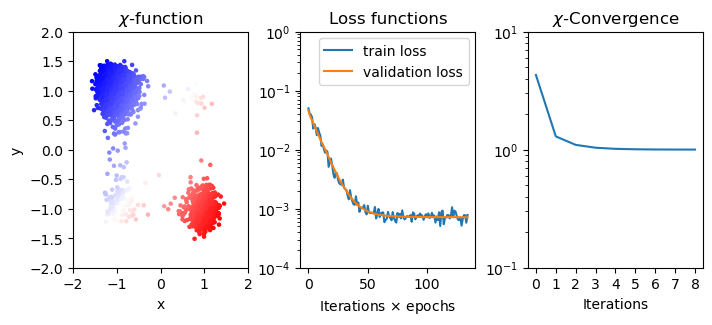

In [5]:
npX0 = X0.cpu().detach().numpy()
chi  =1- f_NN(X0).cpu().detach().numpy()

from sklearn.cross_decomposition import CCA
X1 = np.column_stack((X0[:,0].cpu().detach().numpy(), X0[:,1].cpu().detach().numpy()))  # Shape: (n_samples, 2)
X2 = chi.reshape(-1, 1)           # Shape: (n_samples, 1)

# Initialize and fit CCA
cca = CCA(n_components=1)  # Use one component to capture 1D relationship
cca.fit(X1, X2)

# Transform data into canonical space
X1_c, X2_c = cca.transform(X1, X2)

# Results
print("Canonical Correlation Coefficient:", np.corrcoef(X1_c.T, X2_c.T)[0, 1])


fig, ax = plt.subplots(1, 3, figsize=(16*in2cm, 6*in2cm), facecolor='white')


pos = ax[0].scatter( npX0[:,0], npX0[:,1], c = chi,  cmap = cm.bwr , s = 5 )

ax[0].set_title('$\chi$-function')
ax[0].set_ylim((-2,2))
ax[0].set_xlim((-2,2))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')


ax[1].plot(train_LOSS, label='train loss')
ax[1].plot(val_LOSS, label='validation loss')
ax[1].semilogy()
ax[1].set_xlabel(r'Iterations $\times$ epochs')
ax[1].set_title('Loss functions')
ax[1].legend()
ax[1].set_ylim((0.0001, 1))

ax[2].plot(np.arange(0,len(convergence),1), convergence)
ax[2].semilogy()
ax[2].set_xlabel('Iterations')
ax[2].set_title(r'$\chi$-Convergence')
ax[2].set_xticks(np.arange(0,len(convergence),1))
ax[2].set_ylim((0.1,10))

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.8)
fig.savefig('chi.png', format='png', dpi=900, bbox_inches='tight')

In [6]:
pt.save(f_NN.state_dict(), out_isokann  + 'f_NN.pt')
np.savetxt(out_isokann  + 'val_LOSS.txt', val_LOSS)
np.savetxt(out_isokann  + 'train_LOSS.txt', train_LOSS)
np.save(out_isokann + 'chi0.npy', chi)

# Calculate propagated chi
#chit = f_NN(Xtau).cpu().detach().numpy()
#np.save(out_isokann + 'chit.npy', chit)
